In [2]:
import numpy as np 
import pandas as pd
import sklearn 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.linear_model import RidgeCV 
from sklearn.model_selection import train_test_split
import seaborn as sns


In [3]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


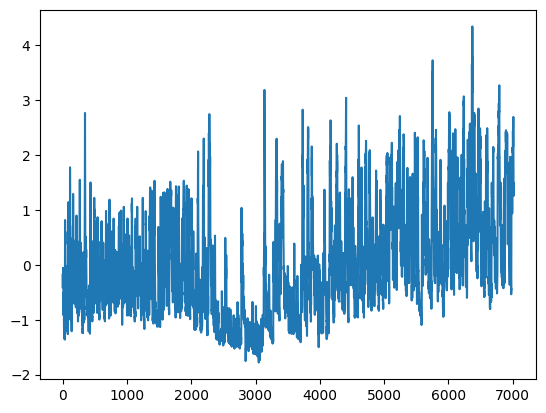

In [5]:

pupil = dat['pupilArea']

pupil= zscore(pupil, ddof = 1)
pupil_t = pupil[:6000]
pupil_p = pupil[6000:]
plt.plot(pupil)

In [6]:
neural_data = dat['sresp']
n_t = neural_data[:,:6000]
n_p = neural_data[:,6000:]

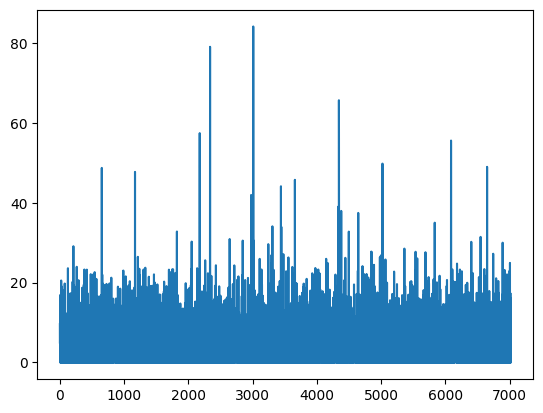

In [7]:
plt.plot(neural_data[1,:])

In [8]:
train_resp, test_resp, train_p, test_p = train_test_split(n_t.T, pupil_t)

In [9]:
train_resp.shape

(4500, 11983)

In [17]:
r = RidgeCV(alphas=np.arange(15), cv = 6)
r.fit(train_resp, train_p)
pred = r.predict(test_resp)
r.score(test_resp, test_p)

c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\linear_model\_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "
c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\linear_model\_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "
c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.66281e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
c:\Users\Valentino\miniconda3\envs\AllenInstituteDatasets\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.9751e-11): result may not be accurate.
  dual_coef = linalg.solv

0.806021083991435

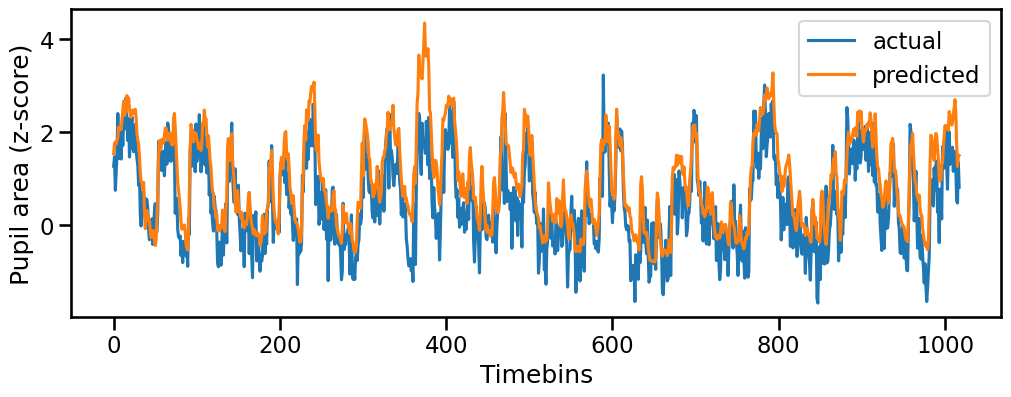

In [20]:
import matplotlib.cm as cm


pupils = np.hstack([r.predict(n_p.T), pupil_p]).T
# r.predict(n_p.T).shape
f = plt.figure(figsize=(12,4))
# cmap = cm.prism
# sns.reset_defaults()
sns.lineplot(pupils.T, 
    # palette={0:'r', 1:'b'}, 
    # alpha =.7,
    dashes=False
    # ,label=['a','b']
    )
plt.legend(labels = ['actual', 'predicted'])
plt.ylabel('Pupil area (z-score)')
plt.xlabel('Timebins')
f.savefig('pupil_stringer.svg', bbox_inches = 'tight')
f.savefig('pupil_stringer.png', bbox_inches = 'tight', transparent=False)

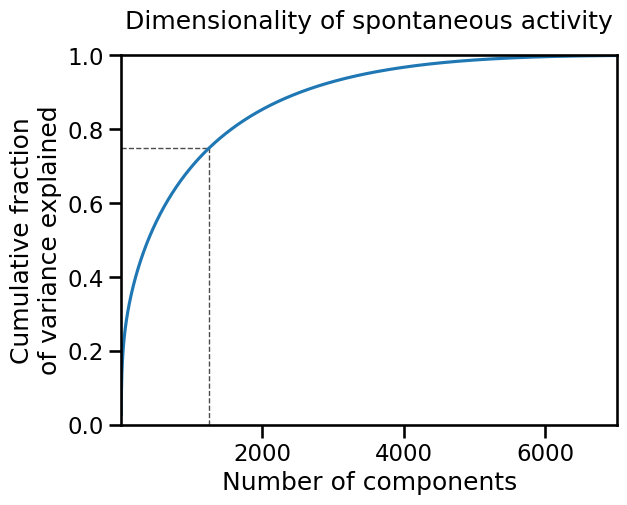

In [29]:
pca = PCA()

X = neural_data.T

pca.fit_transform(X)
scree1 = np.cumsum(pca.explained_variance_ratio_)

sns.set_context('talk')
f, ax = plt.subplots()

lastv = np.where((scree1<0.76) & (scree1>0.75))[0][0]
plt.axvline(x = lastv,ymin = 0, ymax=scree1[lastv], color = 'k', linewidth = 1, linestyle = '--', alpha = .7)
plt.axhline( y= .75,xmin =0 ,  xmax =lastv/X.shape[0],color = 'k', linewidth = 1, linestyle = '--', alpha = .7)

sns.lineplot(y= scree1,x =  np.arange(start =1,stop =  X.shape[0]+1))


ax.set_title('Dimensionality of spontaneous activity', y = 1.05)
ax.set_ylabel('Cumulative fraction\nof variance explained')
ax.set_xlabel('Number of components')

ax.set_xlim([1,X.shape[0]+1])
ax.set_ylim([0,1])

plt.savefig('PCA_stringer.svg', bbox_inches = 'tight', transparent = False)

In [28]:
lastv

1246